In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Data: Synthetic seasonal + trend + noise
We'll create a daily time series spanning ~3 years

In [2]:
date_index = pd.date_range(start='2018-01-01', end='2020-12-31', freq='D')
n = len(date_index)

# Components: trend + yearly seasonality + weekly cycle + noise
trend = np.linspace(0, 5, n)
seasonal = 2.0 * np.sin(2 * np.pi * date_index.dayofyear / 365.25)
weekly = 0.5 * np.sin(2 * np.pi * date_index.dayofweek / 7)
noise = np.random.normal(0, 0.5, n)

ts_values = 10 + trend + seasonal + weekly + noise
df_ts = pd.DataFrame({'date': date_index, 'value': ts_values}).set_index('date')

print("✅ Time-Series dataset created successfully!")
print("Shape:", df_ts.shape)
print("Date range:", df_ts.index.min(), "→", df_ts.index.max())
print("Frequency guess:", pd.infer_freq(df_ts.index))

display(df_ts.head())

✅ Time-Series dataset created successfully!
Shape: (1096, 1)
Date range: 2018-01-01 00:00:00 → 2020-12-31 00:00:00
Frequency guess: D


,value
date,
2018-01-01,10.087374
2018-01-02,10.203021
2018-01-03,10.217872
2018-01-04,10.535206
2018-01-05,10.700278


## Plot the Entire Series
Quickly shows the trend, seasonality, and noise — since we know they were synthetically added.

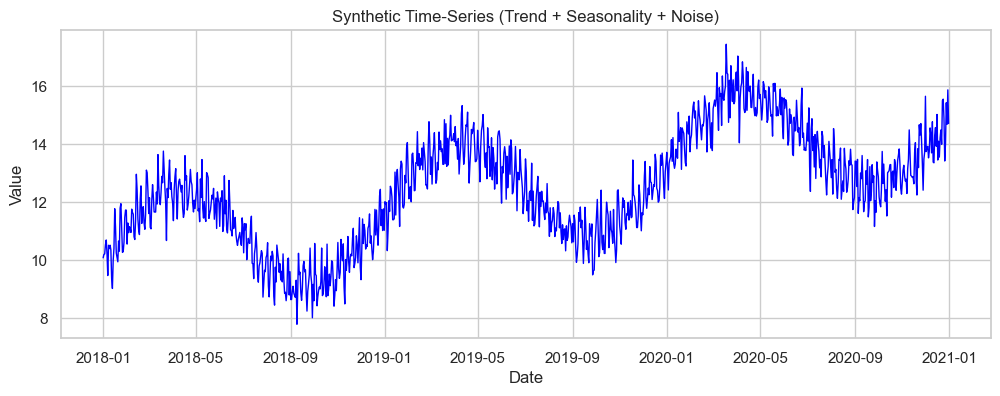

In [3]:
plt.figure(figsize=(12,4))
plt.plot(df_ts.index, df_ts['value'], color='blue', linewidth=1)
plt.title("Synthetic Time-Series (Trend + Seasonality + Noise)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

## Seasonal Decomposition
Let’s separate the trend, seasonal, and residual components.

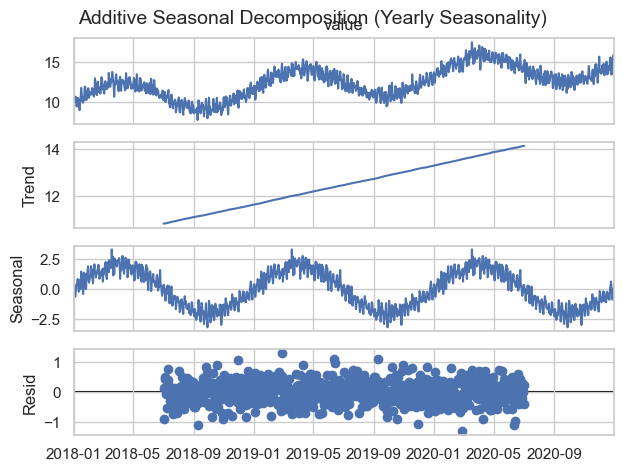

In [4]:
decomp = seasonal_decompose(df_ts['value'], model='additive', period=365)
decomp.plot()
plt.suptitle("Additive Seasonal Decomposition (Yearly Seasonality)", fontsize=14)
plt.show()

We can see your trend (upward), seasonal cycles (sine pattern), and residuals (noise) clearly separated.

## Rolling Statistics (Stability Check)
Detects non-stationarity — trends or changing variance over time.
Stationary series should have flat mean/std lines.

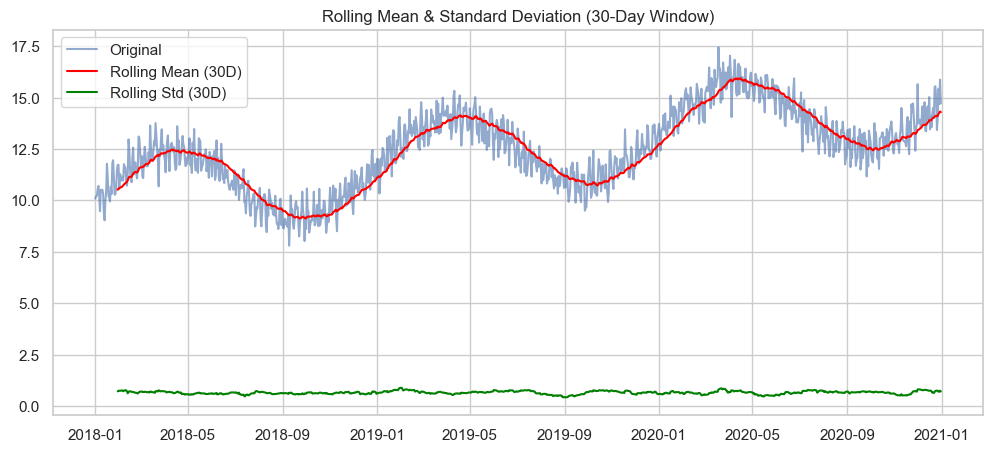

In [5]:
window = 30
rolling_mean = df_ts['value'].rolling(window).mean()
rolling_std = df_ts['value'].rolling(window).std()

plt.figure(figsize=(12,5))
plt.plot(df_ts['value'], label='Original', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean (30D)', color='red')
plt.plot(rolling_std, label='Rolling Std (30D)', color='green')
plt.legend()
plt.title("Rolling Mean & Standard Deviation (30-Day Window)")
plt.show()

## Monthly Average Trends
Highlights long-term pattern evolution — useful for detecting yearly seasonality or slow drift.

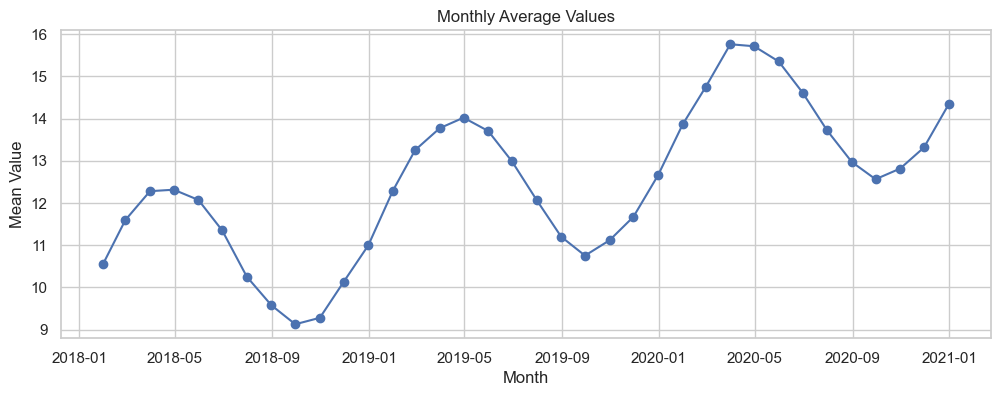

In [6]:
df_monthly = df_ts.resample('M').mean()

plt.figure(figsize=(12,4))
plt.plot(df_monthly.index, df_monthly['value'], marker='o')
plt.title("Monthly Average Values")
plt.xlabel("Month")
plt.ylabel("Mean Value")
plt.grid(True)
plt.show()

## Seasonal Pattern by Month
Confirms how sine-based yearly seasonality peaks mid-year (around July) and dips near January.

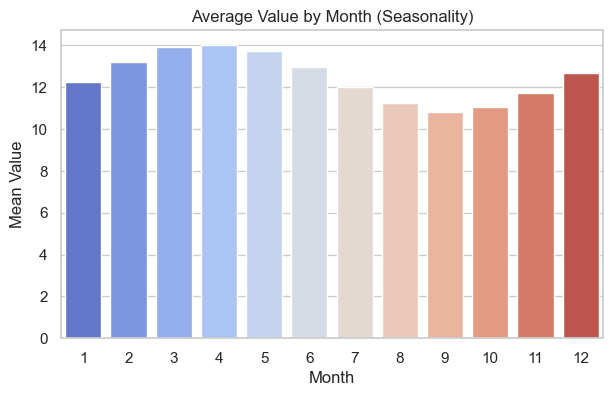

In [7]:
df_ts['month'] = df_ts.index.month
monthly_means = df_ts.groupby('month')['value'].mean()

plt.figure(figsize=(7,4))
sns.barplot(x=monthly_means.index, y=monthly_means.values, palette='coolwarm')
plt.title("Average Value by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Mean Value")
plt.show()

# Remove added column for cleanliness
df_ts.drop(columns='month', inplace=True)

## Autocorrelation (Lag Dependence)
Shows periodic correlation (peaks at seasonal intervals = strong seasonality confirmation).

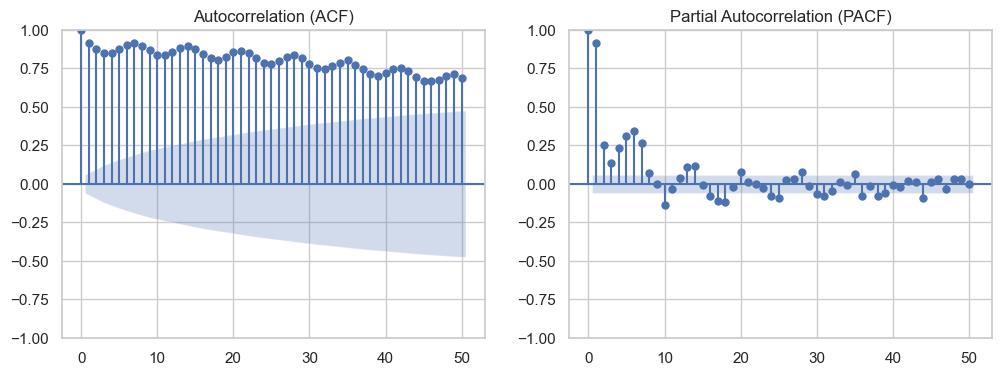

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df_ts['value'], ax=axes[0], lags=50)
plot_pacf(df_ts['value'], ax=axes[1], lags=50)
axes[0].set_title("Autocorrelation (ACF)")
axes[1].set_title("Partial Autocorrelation (PACF)")
plt.show()

## Stationarity Test (ADF Test)
* If **p-value > 0.05**, the series is non-stationary (contains trend/seasonality).
* If **p-value < 0.05**, it’s stationary — ready for ARIMA or similar models.

In [9]:
adf_result = adfuller(df_ts['value'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, val in adf_result[4].items():
    print(f"Critical Value ({key}): {val}")
if adf_result[1] < 0.05:
    print("✅ The series is stationary (reject H0).")
else:
    print("⚠️ The series is non-stationary (contains trend/seasonality).")

ADF Statistic: -1.1742498428901202
p-value: 0.6845735543340389
Critical Value (1%): -3.436441978605957
Critical Value (5%): -2.864229841568573
Critical Value (10%): -2.5682021659802934
⚠️ The series is non-stationary (contains trend/seasonality).


## Simple Forecasting Baseline (Naive Model)

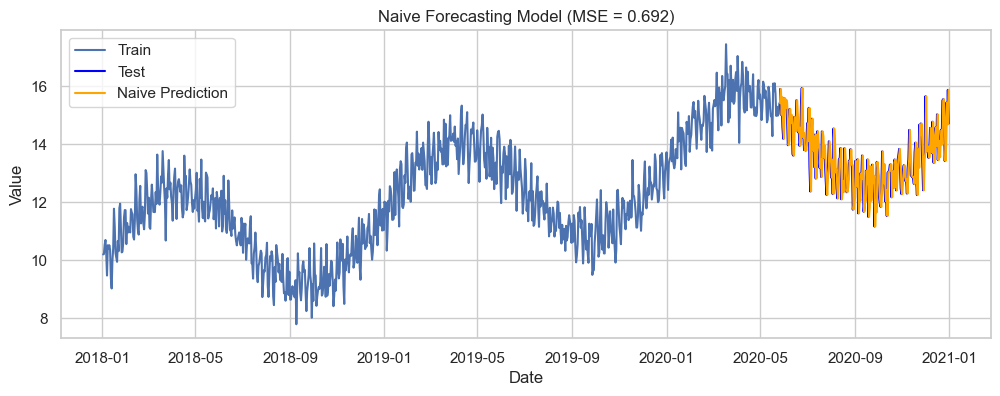

In [10]:
df_ts['lag1'] = df_ts['value'].shift(1)
df_valid = df_ts.dropna()

# Train-test split (80–20)
split_idx = int(0.8 * len(df_valid))
train, test = df_valid.iloc[:split_idx], df_valid.iloc[split_idx:]

# Naive model: predict next = previous
test['pred'] = test['lag1']
mse = mean_squared_error(test['value'], test['pred'])

plt.figure(figsize=(12,4))
plt.plot(train.index, train['value'], label='Train')
plt.plot(test.index, test['value'], label='Test', color='blue')
plt.plot(test.index, test['pred'], label='Naive Prediction', color='orange')
plt.title(f"Naive Forecasting Model (MSE = {mse:.3f})")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

### Checking how well our naive model performed — residuals show where prediction fails.

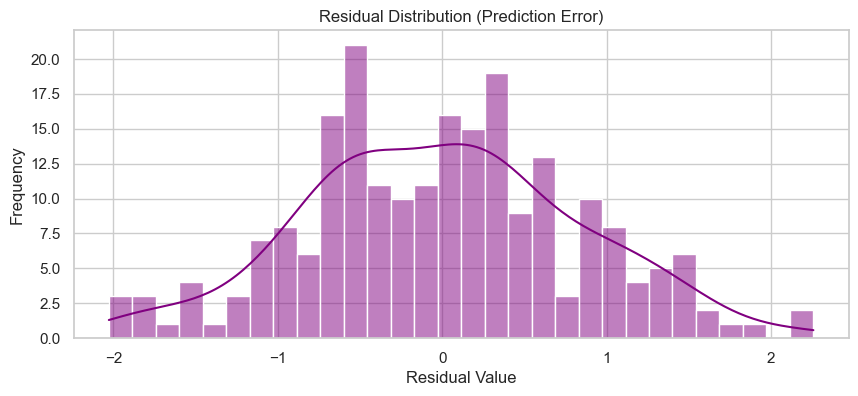

In [11]:
test['residual'] = test['value'] - test['pred']

plt.figure(figsize=(10,4))
sns.histplot(test['residual'], bins=30, kde=True, color='purple')
plt.title("Residual Distribution (Prediction Error)")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()

Ideally, residuals should be centered around zero (no bias) — large tails imply unpredictable components.

## Residuals Over Time

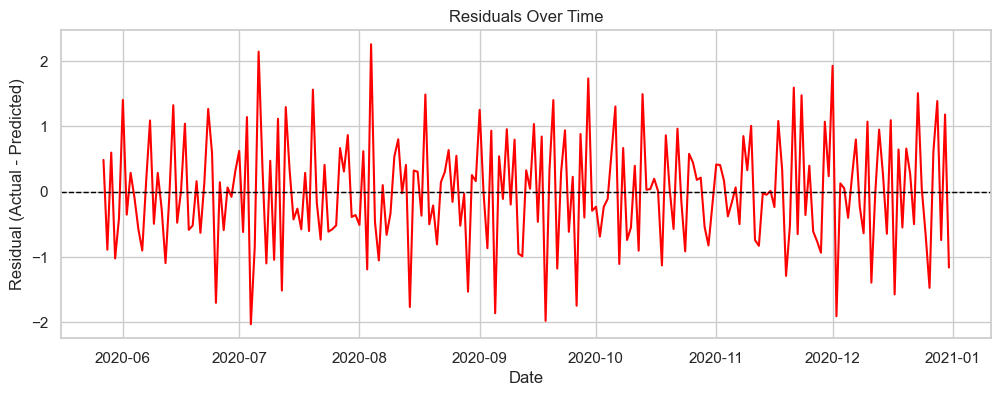

In [12]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test['residual'], color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

Patterns in residuals suggest seasonality or trend remains unmodeled — a hint for improvement.

## Autocorrelation of Residuals

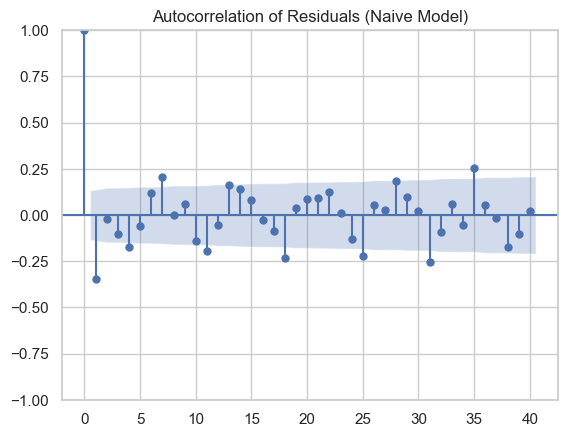

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(test['residual'], lags=40)
plt.title("Autocorrelation of Residuals (Naive Model)")
plt.show()

Significant spikes mean residuals are correlated — the model is too simple.

In [14]:
# Quick Forecast Quality Summary
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test['value'], test['pred'])
rmse = np.sqrt(mean_squared_error(test['value'], test['pred']))

print("🔹 Forecast Performance Summary:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

🔹 Forecast Performance Summary:
Mean Absolute Error (MAE): 0.668
Root Mean Squared Error (RMSE): 0.832


Even with a naive model, these metrics give an intuition of temporal variability and forecast difficulty.

## Forecast Horizon Visualization
Let's zoom in on the last few weeks to compare predicted vs actual more clearly.

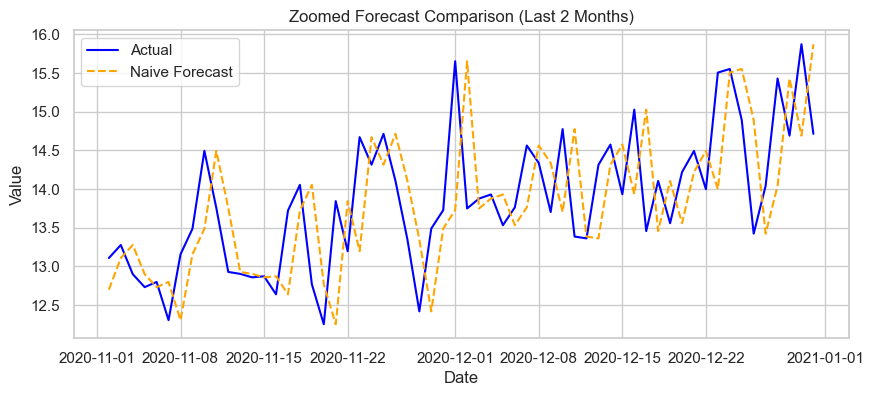

In [15]:
plt.figure(figsize=(10,4))
zoom = test[-60:]
plt.plot(zoom.index, zoom['value'], label='Actual', color='blue')
plt.plot(zoom.index, zoom['pred'], label='Naive Forecast', color='orange', linestyle='--')
plt.title("Zoomed Forecast Comparison (Last 2 Months)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()